In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ada_csl_wrc.evaluation import evaluate

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split

from ada_csl_wrc.models import CostSensitiveDecisionTreeClassifier

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif
from ada_csl_wrc.models import ConstrainedCSDecisionTree
from ada_csl_wrc.models import Constrained
from sklearn.model_selection import train_test_split
from ada_csl_wrc.utils import prediction_up_to_constraint
import pandas as pd
from ada_csl_wrc.utils import prepare_for_cost_cle
from ada_csl_wrc.utils import filter_only_worst_features
from ada_csl_wrc.utils import find_effective_threshold
import json


### Hyperparameters of the experiment

In [22]:
COST_FALSE_NEGATIVE = 10
COST_FALSE_POSITIVE = 1
t = COST_FALSE_POSITIVE/(COST_FALSE_POSITIVE+COST_FALSE_NEGATIVE)
COST_MATRIX = np.array([[0, COST_FALSE_POSITIVE], [COST_FALSE_NEGATIVE, 0]])
FEATURES_RATIO = 0.5

### Data-specific code

This part includes some data-specific code. It is not included in the final model. <br>
The X and the y are the dataframes that are used for training and testing.

In [59]:
df = pd.read_csv('./data/marketing_campaign.csv', sep=";")
df = df.drop(['Z_CostContact', 'Z_Revenue', 'Income', 'Dt_Customer', 'ID'], axis = 1)
X = df.drop(labels = 'Response', axis=1)
y = df['Response']

#Transforming categorial features into numerical
categorial_col = X.select_dtypes(include='object').columns
X[categorial_col] = X[categorial_col].astype('category').apply(lambda x: x.cat.codes)
X = filter_only_worst_features(X, y, FEATURES_RATIO)

In [60]:
def find_best_params(param_grid, X, y):
    # Used for this dataset specifically, to find the best parameters for the decision tree
    # Let's think about more general way to do so.
    grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10, n_jobs=-1, scoring='f1', verbose=3)
    grid.fit(X, y)
    return grid.best_params_

In [61]:
dt_param_grid = {
    "max_depth": [3, 5, 10, 15],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [10, 15, 20, 30]
}

cs_best_params = json.load(open("./config/cost_sensitive_best_params.json", "r")) #hard-coded in a json file
#dt_best_params = find_best_params(dt_param_grid, X, y) #find it using grid search
dt_best_params = {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 20}

If you have reached here, it means that you have in memory the dt_best_params and cs_best_params. <br>
We will inititate our base-classifier based on these params. However, the results of the experiment might be affected by this choice. <br>

## Starting the experiment

In [69]:
constraints_range = 0.25, 0.75
test_size = round(len(X)/3)
int(constraints_range[0]*test_size)

186

### Decision Tree
With best params from the grid search, applying on various of constraints

In [ ]:
def run_constrained_experiment(constrained_model:Constrained, 
                               X, 
                               y, 
                               cost_matrix, 
                               constraint:list, 
                               random_state=42, 
                               n_splits=3):

    fit_params = {}
    out = {}
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    for (fold, (train_index, test_index)) in enumerate(kf.split(X, y)):
        #The ordinary Kfold, but with the constraint
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if isinstance(constrained_model.model, CostSensitiveDecisionTreeClassifier):
            #The Cost Sensitive Decision Tree also needs the cost matrix as a fit parameter
            fit_params['cost_mat'] = prepare_for_cost_cle(len(X_train), cost_matrix)

        constrained_model.fit(X_train, y_train, **fit_params) #Fitting the model

        #The constraint is a float between 0 and 1
        y_pred = constrained_model.predict_constrained(X_test, constraint=constraint)
        out[fold] = evaluate(y_test, y_pred, cost_matrix)

    return pd.DataFrame(out).T.mean(axis=0).to_dict() #Returning the mean of the metrics

results = {}
for constraint in np.arange(0.00, 0.99, 0.005).round(3):
    print(constraint)

    partial_results = run_constrained_experiment(Constrained(DecisionTreeClassifier(**dt_best_params)),
                                X.values,
                                y.values,
                                COST_MATRIX,
                                constraint=constraint)
    results[constraint] = partial_results

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.333)

absolute_constraint = 60
constraint = absolute_constraint/len(y_test)
dt = Constrained(DecisionTreeClassifier(**dt_best_params))
dt.fit(X_train, y_train)
y_pred_constrained = dt.predict_constrained(X_test, constraint=constraint)
evaluate(y_test, y_pred_constrained, COST_MATRIX)

{'cost': 872,
 'accuracy': 0.8324396782841823,
 'precision': 0.3,
 'recall': 0.1782178217821782,
 'f1': 0.2236024844720497}

In [60]:
def run_constrained_experiment(constrained_model:Constrained, 
                               X, 
                               y, 
                               cost_matrix, 
                               constraint:list, 
                               random_state=42, 
                               n_splits=3):

    fit_params = {}
    out = {}
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    for (fold, (train_index, test_index)) in enumerate(kf.split(X, y)):
        #The ordinary Kfold, but with the constraint
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if isinstance(constrained_model.model, CostSensitiveDecisionTreeClassifier):
            #The Cost Sensitive Decision Tree also needs the cost matrix as a fit parameter
            fit_params['cost_mat'] = prepare_for_cost_cle(len(X_train), cost_matrix)

        constrained_model.fit(X_train, y_train, **fit_params) #Fitting the model

        #The constraint is a float between 0 and 1
        y_pred = constrained_model.predict_constrained(X_test, constraint=constraint)
        out[fold] = evaluate(y_test, y_pred, cost_matrix)

    return pd.DataFrame(out).T.mean(axis=0).to_dict() #Returning the mean of the metrics

results = {}
for constraint in np.arange(0.00, 0.99, 0.005).round(3):
    print(constraint)

    partial_results = run_constrained_experiment(Constrained(DecisionTreeClassifier(**dt_best_params)),
                                X.values,
                                y.values,
                                COST_MATRIX,
                                constraint=constraint)
    results[constraint] = partial_results

0.0
0.005
0.01
0.015
0.02


c:\Users\imargolin\Anaconda3\envs\ucp\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\imargolin\Anaconda3\envs\ucp\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\imargolin\Anaconda3\envs\ucp\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.025
0.03
0.035
0.04
0.045
0.05
0.055
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1
0.105
0.11
0.115
0.12
0.125
0.13
0.135
0.14
0.145
0.15
0.155
0.16
0.165
0.17
0.175
0.18
0.185
0.19
0.195
0.2
0.205
0.21
0.215
0.22
0.225
0.23
0.235
0.24
0.245
0.25
0.255
0.26
0.265
0.27
0.275
0.28
0.285
0.29
0.295
0.3
0.305
0.31
0.315
0.32
0.325
0.33
0.335
0.34
0.345
0.35
0.355
0.36
0.365
0.37
0.375
0.38
0.385
0.39
0.395
0.4
0.405
0.41
0.415
0.42
0.425
0.43
0.435
0.44
0.445
0.45
0.455
0.46
0.465
0.47
0.475
0.48
0.485
0.49
0.495
0.5
0.505
0.51
0.515
0.52
0.525
0.53
0.535
0.54
0.545
0.55
0.555
0.56
0.565
0.57
0.575
0.58
0.585
0.59
0.595
0.6
0.605
0.61
0.615
0.62
0.625
0.63
0.635
0.64
0.645
0.65
0.655
0.66
0.665
0.67
0.675
0.68
0.685
0.69
0.695
0.7
0.705
0.71
0.715
0.72
0.725
0.73
0.735
0.74
0.745
0.75
0.755
0.76
0.765
0.77
0.775
0.78
0.785
0.79
0.795
0.8
0.805
0.81
0.815
0.82
0.825
0.83
0.835
0.84
0.845
0.85
0.855
0.86
0.865
0.87
0.875
0.88
0.885
0.89
0.895
0.9
0.905
0.91
0.915
0.92
0.925
0.93
0.935
0.

<Axes: >

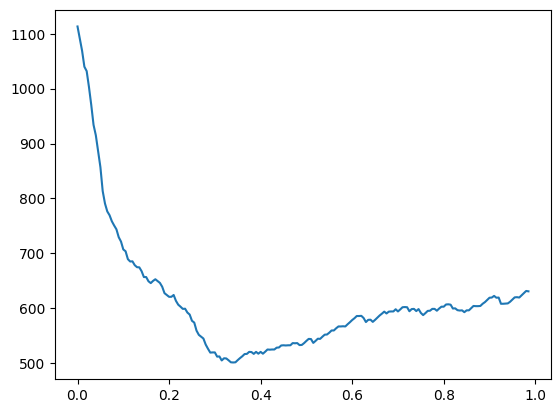

In [65]:
pd.DataFrame(results).T["cost"].plot()

In [38]:
def run_our_experiment(
        X, 
        y, 
        cost_matrix, 
        constraint, 
        random_state=42, 
        n_splits=3, **model_params):
    
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cfn = cost_matrix[1,0]
    out = {}

    for (fold, (train_index, test_index)) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model = ConstrainedCSDecisionTree(constraint=constraint, **model_params)
        model.fit(X_train, y_train, cfn=cfn)
        y_pred = model.predict(X_test)
        out[fold] = evaluate(y_test, y_pred, cost_matrix)

    return pd.DataFrame(out).T.mean(axis=0)

#ConstrainedCSDecisionTree(constraint=0.5).fit(X_train, y_train, cfn=10)
asdasd = run_our_experiment(X.values, y.values, cost_matrix=COST_MATRIX, constraint=0.06702412868632708, **cs_best_params)

Threshold: 0.41 Effective Threshold: 0.52 Cost False Positive: 7.32 Lower Bound: 6.84 Upper Bound: 7.8125000
DONE
Threshold: 0.42
Effective threshold: 0.42
Current cfp:  7.080078125
Lower bound:  6.8359375
Upper bound:  7.32421875
Threshold: 0.49 Effective Threshold: 0.49 Cost False Positive: 8.79 Lower Bound: 7.81 Upper Bound: 9.7722000
DONE
Threshold: 0.47
Effective threshold: 0.47
Current cfp:  8.30078125
Lower bound:  7.8125
Upper bound:  8.7890625
Threshold: 0.49 Effective Threshold: 0.49 Cost False Positive: 8.79 Lower Bound: 7.81 Upper Bound: 9.7722000
DONE
Threshold: 0.47
Effective threshold: 0.47
Current cfp:  8.30078125
Lower bound:  7.8125
Upper bound:  8.7890625


In [40]:
asdasd

cost         855.333333
accuracy       0.858926
precision      0.560000
recall         0.251421
f1             0.347034
dtype: float64

In [158]:
constrained_model = Constrained(DecisionTreeClassifier(**dt_best_params))
#constrained_model = Constrained(CostSensitiveDecisionTreeClassifier(**cs_best_params))
out = run_constrained_experiment(
    constrained_model = constrained_model, 
    X = X.values, 
    y = y.values, 
    cost_matrix = COST_MATRIX, 
    constraint = 0.06702412868632708,#, 0.08042895442359249], 
    random_state=42, 
    n_splits=3)

# fit_params = {}
# fit_params['cost_mat'] = create_cs_matrix(len(X_train), COST_MATRIX)

# model.fit(X_train, y_train, **fit_params)

# out = {}
# for absolute_constraint in range(10, 100, 10):
    
#     constraint = absolute_constraint/len(y_test) #convert to relative constraint

#     y_pred = model.predict_constrained(X_test, constraint=constraint)
#     out[absolute_constraint] = evaluate(y_test, y_pred, COST_MATRIX)
out

Train: 1493 TEST: 747
Train: 1493 TEST: 747
Train: 1494 TEST: 746


cost         774.666667
accuracy       0.878572
precision      0.706667
recall         0.317353
f1             0.438003
dtype: float64

cost         774.666667
accuracy       0.878572
precision      0.706667
recall         0.317353
f1             0.438003
dtype: float64

In [144]:
pd.DataFrame(out[0.06702412868632708]).T

,cost,accuracy,precision,recall,f1
0,1060.0,0.809906,0.20,0.089286,0.123457
1,1017.0,0.819277,0.26,0.117117,0.161491
2,1050.0,0.810992,0.20,0.090090,0.124224


In [146]:
pd.DataFrame({constraint: pd.DataFrame(out[constraint]).mean(axis=1).to_dict() for constraint in out.keys()})

,0.067024,0.080429
cost,1042.333333,1034.000000
accuracy,0.813392,0.804464
precision,0.220000,0.211111
recall,0.098831,0.113819
f1,0.136390,0.147899


In [105]:
{constraint: pd.DataFrame(out[constraint]).mean(axis=1).to_dict() for constraint in out.keys()}

{0.1: {'cost': 441.4,
  'accuracy': 0.8625,
  'precision': 0.5590909090909091,
  'recall': 0.3681592039800995,
  'f1': 0.443963963963964},
 0.2: {'cost': 365.4,
  'accuracy': 0.8111607142857142,
  'precision': 0.39999999999999997,
  'recall': 0.5327453640886477,
  'f1': 0.4569230769230769},
 0.3: {'cost': 289.4,
  'accuracy': 0.7598214285714285,
  'precision': 0.34776119402985073,
  'recall': 0.697467209407508,
  'f1': 0.46410945273631843},
 0.4: {'cost': 283.8,
  'accuracy': 0.6799107142857143,
  'precision': 0.28603351955307266,
  'recall': 0.7666214382632294,
  'f1': 0.416618549858968},
 0.5: {'cost': 302.4,
  'accuracy': 0.5901785714285714,
  'precision': 0.23928571428571427,
  'recall': 0.8025780189959294,
  'f1': 0.3686550539163408}}

In [91]:
pd.DataFrame(out[0.1]).mean(axis=1)

cost         443.600000
accuracy       0.861607
precision      0.554545
recall         0.365174
f1             0.440360
dtype: float64

In [80]:
#pd.json_normalize(out)

pd.DataFrame(out).T

,0,1,2
0.1,"{'cost': 776, 'accuracy': 0.8527443105756358, ...","{'cost': 711, 'accuracy': 0.8674698795180723, ...","{'cost': 766, 'accuracy': 0.853887399463807, '..."
0.2,"{'cost': 587, 'accuracy': 0.8165997322623829, ...","{'cost': 632, 'accuracy': 0.8045515394912985, ...","{'cost': 610, 'accuracy': 0.8096514745308311, ..."
0.3,"{'cost': 508, 'accuracy': 0.7536813922356091, ...","{'cost': 487, 'accuracy': 0.7576974564926372, ...","{'cost': 486, 'accuracy': 0.7587131367292225, ..."
0.4,"{'cost': 538, 'accuracy': 0.6653279785809906, ...","{'cost': 484, 'accuracy': 0.677376171352075, '...","{'cost': 484, 'accuracy': 0.6769436997319035, ..."
0.5,"{'cost': 558, 'accuracy': 0.5783132530120482, ...","{'cost': 515, 'accuracy': 0.5876840696117804, ...","{'cost': 493, 'accuracy': 0.5924932975871313, ..."


In [57]:
StratifiedKFold??

Init signature: StratifiedKFold(n_splits=5, *, shuffle=False, random_state=None)
Source:        
class StratifiedKFold(_BaseKFold):
    """Stratified K-Folds cross-validator.

    Provides train/test indices to split data in train/test sets.

    This cross-validation object is a variation of KFold that returns
    stratified folds. The folds are made by preserving the percentage of
    samples for each class.

    Read more in the :ref:`User Guide <stratified_k_fold>`.

    For visualisation of cross-validation behaviour and
    comparison between common scikit-learn split methods
    refer to :ref:`sphx_glr_auto_examples_model_selection_plot_cv_indices.py`

    Parameters
    ----------
    n_splits : int, default=5
        Number of folds. Must be at least 2.

        .. versionchanged:: 0.22
            ``n_splits`` default value changed from 3 to 5.

    shuffle : bool, default=False
        Whether to shuffle each class's samples before splitting into batches.
        Note that t

In [ ]:
def run_constrained_experiment(clf:Constrained, X, y, cost_matrix, constraint, random_state=42):

    fit_params = {}
    out = []

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    #kf.get_n_splits(X)
    for (train_index, test_index) in kf.split(X, y):
        print("Train:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        if isinstance(clf, CostSensitiveDecisionTreeClassifier):
            #If type of CostSensitiveDecisionTreeClassifier, then create a cost matrix for the training set
            fit_params['cost_mat'] = prepare_for_cost_cle(len(X_train), cost_matrix)

        clf.fit(X_train, y_train, **fit_params) 
        y_pred_proba = clf.predict_proba(X_test)[:, 1] #get the probability of the positive class

        if constraint:
            y_pred = prediction_up_to_constraint(y_pred_proba, constraint) 
        else:
            y_pred = clf.predict(X_test)
        
        out.append(evaluate(y_test, y_pred, cost_matrix))
    return out

In [56]:
pd.DataFrame(out).T

,cost,accuracy,precision,recall,f1
10,1039.0,0.849866,0.100000,0.009615,0.017544
20,1049.0,0.836461,0.050000,0.009615,0.016129
30,1048.0,0.825737,0.066667,0.019231,0.029851
40,1058.0,0.812332,0.050000,0.019231,0.027778
50,1068.0,0.798928,0.040000,0.019231,0.025974
60,1067.0,0.788204,0.050000,0.028846,0.036585
70,1055.0,0.780161,0.071429,0.048077,0.057471
80,1054.0,0.769437,0.075000,0.057692,0.065217
90,1042.0,0.761394,0.088889,0.076923,0.082474


In [31]:
cs_dt = ConstrainedClassifier(CostSensitiveDecisionTreeClassifier(**cs_best_params), constraint=constraint)
cs_dt.fit(X_train, y_train, cost_mat = prepare_for_cost_cle(len(X_train), COST_MATRIX))


ConstrainedClassifier(constraint=0.0938337801608579,
                      model=CostSensitiveDecisionTreeClassifier(max_depth=5,
                                                                min_samples_leaf=15))

In [33]:
cs_dt.predict_constrained(X_test)

array([1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [28]:
dt.prediction_up_to_constraint(X_test).sum()

50.0

In [120]:
print("line1", end = "\r")
print("line2")

line2


In [135]:
ccsdt = ConstrainedCSDecisionTree(num_iterations=60, constraint=constraint, **cs_best_params)
ccsdt.fit(X_train, y_train, cfn= COST_FALSE_NEGATIVE)

Threshold: 0.33 Effective Threshold: 0.46 Cost False Positive: 50.290
DONE
Threshold: 0.33
Effective threshold: 0.33
Current cfp:  50.048828125
Lower bound:  49.8046875
Upper bound:  50.29296875


ConstrainedCSDecisionTree(constraint=0.11160714285714286, num_iterations=60)

In [136]:
y_pred = ccsdt.predict(X_test)

In [141]:
evaluate(y_test, y_pred, COST_MATRIX)

{'cost': 4224,
 'accuracy': 0.8526785714285714,
 'precision': 0.52,
 'recall': 0.38235294117647056,
 'f1': 0.4406779661016949}

In [41]:
ccsdt.best_model.predict_proba(X_)

<bound method CostSensitiveDecisionTreeClassifier.predict_proba of CostSensitiveDecisionTreeClassifier(max_depth=5, min_samples_leaf=15)>

In [77]:
buga = ccsdt.best_model.predict_proba(X_test)[:,1]
t = 50/(50+COST_FALSE_NEGATIVE)
(buga > t).mean()

0.11607142857142858

In [82]:
my_predict = ccsdt.best_model.predict_proba(X_test)[:,1] > t
my_predict = my_predict.astype(int)

ccsdt.best_model.predict(X_test) == my_predict

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [62]:
buga.nlargest(40)

269    0.630435
298    0.630435
62     0.630435
187    0.630435
289    0.630435
221    0.630435
282    0.630435
181    0.630435
293    0.630435
420    0.630435
86     0.630435
33     0.630435
253    0.630435
61     0.630435
367    0.630435
365    0.630435
277    0.630435
36     0.630435
235    0.630435
113    0.630435
317    0.630435
38     0.630435
410    0.630435
142    0.630435
141    0.630435
398    0.524272
57     0.524272
274    0.524272
200    0.524272
224    0.524272
77     0.524272
209    0.524272
295    0.524272
375    0.524272
300    0.524272
165    0.524272
311    0.524272
119    0.524272
120    0.524272
342    0.524272
dtype: float64

In [69]:
buga = ccsdt.best_model.predict_proba(X_test)[:, 1]
buga = pd.Series(buga)

buga.nlargest(40)

# buga.iloc[:52].min()

33     0.630435
36     0.630435
38     0.630435
61     0.630435
62     0.630435
86     0.630435
113    0.630435
141    0.630435
142    0.630435
181    0.630435
187    0.630435
221    0.630435
235    0.630435
253    0.630435
269    0.630435
277    0.630435
282    0.630435
289    0.630435
293    0.630435
298    0.630435
317    0.630435
365    0.630435
367    0.630435
410    0.630435
420    0.630435
3      0.524272
6      0.524272
20     0.524272
34     0.524272
57     0.524272
77     0.524272
119    0.524272
120    0.524272
165    0.524272
189    0.524272
200    0.524272
209    0.524272
224    0.524272
230    0.524272
240    0.524272
dtype: float64

In [44]:
ccsdt.predict(X_test)

array([0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0.

In [ ]:
buga = CostSensitiveDecisionTreeClassifier(**cs_best_params)

cost_mat_train = prepare_for_cost_cle(len(X), np.array([[0, 1], [1000, 0]]))
cost_mat_train

buga.fit(X.values, y.values, cost_mat=cost_mat_train)

In [ ]:
buga.predict(X.values).mean()

In [ ]:
y_pred = buga.predict_proba(X.values)[:, 1]
ax = pd.cut(pd.Series(y_pred), bins = np.linspace(0,1,11)).value_counts(normalize=True).plot.bar(grid=True)
ax.set_ylabel('Percentage of samples')
ax.set_yticks(np.linspace(0, 1, 11))

In [ ]:
pd.Series().plot.hist(bins=np.linspace(0,1,11), density=True)

In [ ]:
clf_cs_dt = CostSensitiveDecisionTreeClassifier()
clf_cs_dt.set_params(**cs_best_params)

clf_dt = DecisionTreeClassifier()
clf_dt.set_params(**dt_best_params)

In [ ]:
clf_dt.fit(X, y)
y_pred = clf_dt.predict_proba(X)[:, 1]
y_pred = prediction_up_to_constraint(y_pred, 3000)
evaluate(y, y_pred, COST_MATRIX)


In [ ]:
confusion_matrix(y, y_pred)

In [ ]:
# buga = full_experiment(
#     clf=clf_cs_dt, 
#     random_state=42, 
#     X=X.values, 
#     y=y.values, 
#     cost_matrix=COST_MATRIX, 
#     constraint=None)

In [ ]:
classfication_report_with_cost(y, y_pred, COST_MATRIX)

In [ ]:
classfication_report_with_cost(y, y_pred, COST_MATRIX)

In [ ]:
confusion_matrix(y, y_pred)

In [183]:
buga = prepare_for_cost_cle(len(y), COST_MATRIX)

In [ ]:
clf_cs_dt.fit(X.values, y.values, buga)

In [ ]:
clf_cs_dt.predict_proba(X.values)[:, 1]

In [ ]:
X = df.drop(labels = 'Response', axis=1)
y = df['Response']

# drop columns
worst_features =[]
for i,v in enumerate(mutual_info):
    if v in sorted(mutual_info)[:17]: # update to 0.75*num_of_features
        worst_features.append(i)
print(worst_features)
X_17 = X.iloc[:, worst_features]
X_17 = X_17.to_numpy()

worst_features =[]
for i,v in enumerate(mutual_info):
    if v in sorted(mutual_info)[:11]: # update to 0.5*num_of_features
        worst_features.append(i)
print(worst_features)
X_11 = X.iloc[:, worst_features]
X_11 = X_11.to_numpy()

X = X.to_numpy()
y = y.to_numpy()
r = y*cfn +(1-y)*(-cfp)

In [ ]:
y*COST_FALSE_NEGATIVE + (1-y)*(-COST_FALSE_POSITIVE)

In [21]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# cost_mat_train_i = cost_mat(1,10,y_train)
# clf_cs_dt.fit(np.array(X_train),np.array(y_train), cost_mat_train_i)
# y_pred_proba_i= clf_cs_dt.predict_proba(np.array(X_train))
# y_pred_probs_i = [y_pred_proba_i[j][1] for j in range(len(y_pred_proba_i))]
# d_t_i = get_dynamic_threshold(y_pred_probs_i,100,0.5)

In [ ]:
#apply the experimnt on differnt slices of the dataset
clf_cs_dt = CostSensitiveDecisionTreeClassifier(min_samples_leaf = best_combination[0], max_depth = best_combination[1],
                                              pruned = best_combination[2], min_gain = best_combination[3])

# for smoozing the graph - repeat the experiment with 10 different CV
random_state_list = [24]#, 6, 18, 32, 76, 5, 40, 12, 31, 9]
constraint = [50, 60]
result_dict_all, result_dict_075, result_dict_05 = {}, {}, {}
for random_state in random_state_list:
    print('********', random_state, '********')

    fold_dict_all = experiment(clf_cs_dt, clf_dt, random_state, X, y, cfp, cfn, constraint)
    result_dict_all[random_state] = fold_dict_all

#     fold_dict_075 = experiment(clf, clf_dt, random_state, X_17, y, r, cfp, cfn, constraint)
#     result_dict_075[random_state] = fold_dict_075

#     fold_dict_05 = experiment(clf, clf_dt, random_state, X_11, y, r, cfp, cfn, constraint)
#     result_dict_05[random_state] = fold_dict_05



In [ ]:
# #save data
# with open('result_dict_05.pickle', 'wb') as handle:
#     pickle.dump(result_dict_05, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('result_dict_075.pickle', 'wb') as handle:
#     pickle.dump(result_dict_075, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('result_dict_all.pickle', 'wb') as handle:
#     pickle.dump(result_dict_all, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# #load data
# #random_state_list = [24, 6, 18, 32, 76, 5, 40, 12, 31, 9]

# with open('marketing_result_dict_11_v2.pickle', 'rb') as handle:
#     marketing_result_dict_11 = pickle.load(handle)

# with open('marketing_result_dict_17_v2.pickle', 'rb') as handle:
#     marketing_result_dict_17 = pickle.load(handle)

# with open('marketing_result_dict_all_v2.pickle', 'rb') as handle:
#     marketing_result_dict_all = pickle.load(handle)

In [ ]:
result_dict_all[24][1]["cs"]

In [ ]:
pd.DataFrame(result_dict_all[24][1]['cs'])

In [ ]:
pd.DataFrame(result_dict_all[24][1]["optimal"])

In [28]:
cs_measure, dt_measure, one_before_measure, itr_list = get_measure_list(result_dict_all, 'cost', random_state_list, constraint)

In [ ]:
one_before_measure

In [ ]:
plt.plot(constraint, get_mean_list(one_before_measure), label = 'AdaCSL-WRC')
plt.plot(constraint, get_mean_list(cs_measure), label = 'CS-DT')
plt.plot(constraint, get_mean_list(dt_measure), label = 'DT')
plt.ylabel('Cost')
plt.xlabel('Constraint')
plt.legend()
plt.show()

In [ ]:
#create conda env
#conda create --name AdaCSL_WRC python=3.7

In [ ]:
!pip freeze

In [ ]:
!pip freeze